## Iterative Proportional Fitting

This notebook performs iterative proportional fitting ("raking") on the variables `Age`, `RaceEthnicity`, `Insurance`, `Education`, `Income`, and `Sex`. Weights are computed for a source sample so that specified marginal distributions match those of a weighted target population. The raking procedure can use all six variables or as few as any two of them.

The source and target datasets **must** obey an identical coding scheme. This notebook **assumes** that both the source and target datasets have been recoded accordingly.

In [1]:
import os
import re
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tabulate import tabulate
from collections import Counter, defaultdict

from src import plots, pdf, raking, census_divisions as census

# coding file - ensure that the input files were generated with the selected coding scheme
from src import coding_pums as CODING

### User Parameters

These parameters control the raking process. These are the only variables in the notebook that users should modify.

In [2]:
#
# RAKING VARIABLES
#
# This data structure contains various identifiers for the variables to be raked.
# It is a list of three-component tuples for each variable.
#
# The left column specifies the variable type from the coding file.
#
# The middle column specifies the name of this variable in the SOURCE file.
#
# The right column specifies the name of this variable in the TARGET (PUMS) file.
#
# Users will only need to change the name strings in the MIDDLE column.

RAKE_DATA = [
    # variable,                   # source file column name,   # PUMS file column name
    (CODING.Variables.AGE,        'AGE_GROUPING',              'Age'),          
    (CODING.Variables.RACE_ETH,   'RACE_GROUPING',             'RaceEth'),
    (CODING.Variables.INSURANCE,  'INSURANCE_GROUPING',        'Insurance'),
    (CODING.Variables.EDUCATION,  'EDUCATION_GROUPING',        'Education'),
    (CODING.Variables.INCOME,     'INCOME_GROUPING',           'Income'),  
    (CODING.Variables.SEX,        'SEX_AT_BIRTH',              'Sex'),        
]


#
# MIN_CELL_SIZE
#
#
# Any raking model that produces source variable marginal distributions with fewer
# than this many samples in a single category will be discarded.
#
# The purpose of this integer variable is to identify raking models that are likely to produce
# large maximum weights. Large values in the upper tail of the weight distribution tend to
# overweight relatively rare individuals, which causes them to represent an unrealistic percentage
# of the final weighted population.
#
# A suitable minimum value for this variable is 50.
MIN_CELL_SIZE = 50


#
# DATA DIR
# 
# This is the name of the directory where the source and target RECODED input files
# can be found. It is assumed to be relative to the directory containing this notebook.
# This directory must exist.
DATA_DIR = 'data'


#
# TARGET_FILE_NAME
#
# The NAME of the recoded PUMS file for all 50 states and DC.
# This file name is assumed to be relative to DATA_DIR.
TARGET_FILE_NAME = 'pums_usa_2019_recoded.csv'


#
# TARGET_WEIGHT_COL
#
# The NAME of the weight column in the target file.
# For PUMS data this variable should be set to the string 'PWGTP'.
# For unweighted target data, set this to the python special value None.
TARGET_WEIGHT_COL = 'PWGTP'


#
# SOURCE_FILE_NAME
# 
# The NAME of the recoded source dataset.
# This file name is assumed to be relative to DATA_DIR.
SOURCE_FILE_NAME = 'synthetic_nhis.csv'


#
# SOURCE_STATE_COL
#
# The name of the column in the source data file containing the two-letter state code.
SOURCE_STATE_COL = 'STATE'


#
# SOURCE_STATE
#
# This string is a two-letter US state abbreviation or one of the following abbreviations for a
# US census division. One would use census division identifiers for regional weighting,
# for instance.
#
# Census division identifiers:
#     'DIV_NE'   (Northeast)
#     'DIV_MA'   (Middle Atlantic)
#     'DIV_ENC'  (East North Central)
#     'DIV_WNC'  (West North Central)
#     'DIV_SA'   (South Atlantic)
#     'DIV_ESC'  (East South Central)
#     'DIV_WSC'  (West South Central)
#     'DIV_M'    (Mountain)
#     'DIV_P'    (Pacific)
SOURCE_STATE = 'CA'


#
# TARGET_STATE
# 
# This string is a two-letter US state abbreviation for the 50 states.
# For Washington DC use the string 'DC'. Census divisions cannot be used for this variable.
# 
# If SOURCE_STATE is a census division, the target state MUST also be found in that census division.
TARGET_STATE = 'CA'


#
# OUTPUT_FILE_NAME
# 
# A weighted version of the source file will be written to the file with this name.
# This name is relative to DATA_DIR.
OUTPUT_FILE_NAME = 'weighted_{0}_{1}.csv'.format(SOURCE_STATE.lower(), TARGET_STATE.lower())

### End of User Parameters

#### Consistency checks on user params

In [3]:
# must rake on at least two variables
if len(RAKE_DATA) < 2:
    raise SystemExit('Raking must be performed on two or more variables.')
    
# mininum cell size must be a nonnegative int
if int != type(MIN_CELL_SIZE) or MIN_CELL_SIZE < 0:
    raise SystemExit('The minimum cell size must be a nonnegative integer.')
    
# find the DATA_DIR
if not os.path.isdir(DATA_DIR):
    raise SystemExit('DATA_DIR not found: "{0}".'.format(DATA_DIR))
    
# find the recoded source file
source_file = os.path.join(DATA_DIR, SOURCE_FILE_NAME)
if not os.path.isfile(source_file):
    raise SystemExit('Source file "{0}" not found.')
    
# find the recoded target file
target_file = os.path.join(DATA_DIR, TARGET_FILE_NAME)
if not os.path.isfile(target_file):
    raise SystemExit('Target file "{0}" not found.')
    
# check the source and target states
if not census.is_valid(SOURCE_STATE, TARGET_STATE):
    raise SystemExit()    

### Setup some data structures

In [4]:
# map of variable enum to source file col name
SOURCE_COL_MAP = {RAKE_DATA[i][0]:RAKE_DATA[i][1] for i in range(len(RAKE_DATA))}

# map of variable enum to PUMS file col name
TARGET_COL_MAP = {RAKE_DATA[i][0]:RAKE_DATA[i][2] for i in range(len(RAKE_DATA))}

# get the names of the variables, in order
RAKEVAR_NAMES = [CODING.VAR_NAMES[enumvar] for enumvar, source_col, tgt_col in RAKE_DATA]
print('Variable order: {0}'.format(RAKEVAR_NAMES))  

# bin counts, in order of the variables
BIN_COUNTS = [CODING.BIN_COUNTS[enumvar] for enumvar, source_col, tgt_col in RAKE_DATA]

# maximum-length variable name, used for prettyprinting
maxlen = max([len(var_name) for var_name in RAKEVAR_NAMES])
print('\nBin counts: ')
for q in range(len(RAKEVAR_NAMES)):
    print('{0:>{2}} : {1}'.format(RAKEVAR_NAMES[q], BIN_COUNTS[q], maxlen))

Variable order: ['Age', 'RaceEth', 'Insurance', 'Education', 'Income', 'Sex']

Bin counts: 
      Age : 6
  RaceEth : 5
Insurance : 2
Education : 4
   Income : 4
      Sex : 2


### Load the PUMS data for the USA

In [5]:
# recoded PUMS file for the entire USA
TARGET_FILE = os.path.join(DATA_DIR, TARGET_FILE_NAME)
print('Loading target file "{0}" ...'.format(TARGET_FILE))
pums_usa_df = pd.read_csv(TARGET_FILE)
pums_usa_df

Loading target file "data/pums_usa_2019_recoded.csv" ...


,Age,Education,Income,Insurance,PWGTP,RaceEth,SERIALNO,SPORDER,ST,Sex
0,2,1,2,0,23,3,2019HU0915504,1,1,0
1,4,2,1,0,71,0,2019HU0915555,1,1,1
2,5,0,0,0,53,0,2019HU0915555,2,1,0
3,5,2,1,0,25,1,2019HU0915664,1,1,1
4,0,0,2,0,38,0,2019HU0915711,1,1,1
...,...,...,...,...,...,...,...,...,...,...
2599166,3,1,2,0,125,0,2019HU1000576,1,56,0
2599167,3,1,0,0,134,0,2019HU1000576,2,56,1
2599168,4,2,0,0,24,0,2019HU1000791,1,56,1
2599169,1,0,1,0,48,3,2019HU0999472,1,56,1


#### Extract PUMS data for the target state

In [6]:
def get_pums_state_data(pums_usa_df, state_abbrev):
    
    # extract PUMS data for the specified state
    assert state_abbrev in census.STATE_CODE_MAP
    state_code = census.STATE_CODE_MAP[state_abbrev]

    # extract all rows for this state
    pums_df = pums_usa_df.loc[pums_usa_df['ST'] == state_code]

    # keep specified data cols and weight col, drop all others
    keep_cols = [col for col in TARGET_COL_MAP.values()]
    keep_cols.append(TARGET_WEIGHT_COL)
    pums_df = pums_df[keep_cols]
    pums_df = pums_df.reset_index(drop=True)
    return pums_df

### Load the source data

In [7]:
SOURCE_FILE = os.path.join(DATA_DIR, SOURCE_FILE_NAME)
raw_source_df = pd.read_csv(SOURCE_FILE)

# extract required cols
cols = [c for c in SOURCE_COL_MAP.values()]
cols.append(SOURCE_STATE_COL)
raw_source_df = raw_source_df[cols]
raw_source_df

,AGE_GROUPING,RACE_GROUPING,INSURANCE_GROUPING,EDUCATION_GROUPING,INCOME_GROUPING,SEX_AT_BIRTH,STATE
0,5,0,0,0,2,0,CA
1,4,1,0,3,0,1,CA
2,4,0,0,2,0,1,CA
3,2,0,0,3,2,1,CA
4,0,1,0,0,2,1,CA
...,...,...,...,...,...,...,...
42370,0,0,1,2,0,1,SD
42371,1,1,0,0,3,1,SD
42372,0,3,0,3,2,0,SD
42373,3,3,0,0,2,1,SD


#### Extract data for the source state

In [8]:
def get_source_data(raw_source_df, source_state_abbrev, target_state_abbrev):
    """
    Extract data for the desired state or census division from the raw sourc data file.
    """
        
    if source_state_abbrev in census.STATE_CODE_MAP:
        # single state
        state_set = {source_state_abbrev}
    else:
        assert source_state_abbrev in census.STATE_DIVISION_MAP
        division = census.STATE_DIVISION_MAP[source_state_abbrev]
        state_tuples = census.CENSUS_DIV_MAP[division]
        state_set = {abbrev for abbrev, code in state_tuples}
        print('States in census division {0}: {1}'.format(division, sorted(list(state_set))))
        
        if target_state not in state_set:
            raise ValueError('Target state must be located in the specified census division.')

    # extract data for desired state(s)
    source_df = raw_source_df[raw_source_df[SOURCE_STATE_COL].isin(state_set)]

    source_df = source_df.reset_index(drop=True)
    print('States in dataframe: {0}'.format(sorted(list(source_df[SOURCE_STATE_COL].unique()))))
    return source_df

## Raking in N Dimensions

In [9]:
# load the PUMS data for the target state
target_df = get_pums_state_data(pums_usa_df, TARGET_STATE)

# load the source data, either for a single state or a census division
source_df = get_source_data(raw_source_df, SOURCE_STATE, TARGET_STATE)

# call the raking code to run all models for the problem dimension (model_list = None)
result_df, weight_map = raking.rake(RAKE_DATA,
                                    source_df,
                                    target_df,
                                    BIN_COUNTS,
                                    MIN_CELL_SIZE,
                                    TARGET_WEIGHT_COL,
                                    model_list = None)

States in dataframe: ['CA']

Source columns, in order: 
	AGE_GROUPING
	RACE_GROUPING
	INSURANCE_GROUPING
	EDUCATION_GROUPING
	INCOME_GROUPING
	SEX_AT_BIRTH

Target columns, in order: 
	Age
	RaceEth
	Insurance
	Education
	Income
	Sex

Target population (weighted): 30632359

[1/76]	Model [[0], [1], [2], [3], [4], [5]]:

ipfn converged: convergence_rate below threshold
	Max weight: 12620.121

[2/76]	Model [[0], [1], [2], [3], [4, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 15123.584

[3/76]	Model [[0], [1], [2], [4], [3, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 12794.472

[4/76]	Model [[0], [1], [2], [5], [3, 4]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 14026.481

[5/76]	Model [[0], [1], [3], [4], [2, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 13497.115

[6/76]	Model [[0], [1], [3], [5], [2, 4]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 17040.310

[7/76]	Model [[0], [1], [4], [5], [2, 3]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 12717.851

[8/76]	Model [[0], [2], [3], [4], [1, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 13188.209

[9/76]	Model [[0], [2], [3], [5], [1, 4]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 12432.681

[10/76]	Model [[0], [2], [4], [5], [1, 3]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 13224.552

[11/76]	Model [[0], [3], [4], [5], [1, 2]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 19679.691

[12/76]	Model [[1], [2], [3], [4], [0, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 13630.638

[13/76]	Model [[1], [2], [3], [5], [0, 4]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 17801.960

[14/76]	Model [[1], [2], [4], [5], [0, 3]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 18429.179

[15/76]	Model [[1], [3], [4], [5], [0, 2]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 16566.178

[16/76]	Model [[2], [3], [4], [5], [0, 1]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 17364.668

[17/76]	Model [[0], [1], [2, 3], [4, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 15162.540

[18/76]	Model [[0], [1], [2, 4], [3, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 17364.474

[19/76]	Model [[0], [1], [2, 5], [3, 4]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 15051.891

[20/76]	Model [[0], [2], [1, 3], [4, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 15576.584

[21/76]	Model [[0], [2], [1, 4], [3, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 12662.806

[22/76]	Model [[0], [2], [1, 5], [3, 4]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 14718.213

[23/76]	Model [[0], [3], [1, 2], [4, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 24142.590

[24/76]	Model [[0], [3], [1, 4], [2, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 13353.839

[25/76]	Model [[0], [3], [1, 5], [2, 4]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 17911.595

[26/76]	Model [[0], [4], [1, 2], [3, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 20082.980

[27/76]	Model [[0], [4], [1, 3], [2, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 14147.011

[28/76]	Model [[0], [4], [1, 5], [2, 3]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 13182.030

[29/76]	Model [[0], [5], [1, 2], [3, 4]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 21112.146

[30/76]	Model [[0], [5], [1, 3], [2, 4]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 17565.944

[31/76]	Model [[0], [5], [1, 4], [2, 3]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 12524.073

[32/76]	Model [[1], [2], [0, 3], [4, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 21888.458

[33/76]	Model [[1], [2], [0, 4], [3, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 17915.617

[34/76]	Model [[1], [2], [0, 5], [3, 4]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 15031.134

[35/76]	Model [[1], [3], [0, 2], [4, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 20680.917

[36/76]	Model [[1], [3], [0, 4], [2, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 18849.336

[37/76]	Model [[1], [3], [0, 5], [2, 4]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 18218.320

[38/76]	Model [[1], [4], [0, 2], [3, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 16958.622

[39/76]	Model [[1], [4], [0, 3], [2, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 19983.598

[40/76]	Model [[1], [4], [0, 5], [2, 3]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 13725.134

[41/76]	Model [[1], [5], [0, 2], [3, 4]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 17517.772

[42/76]	Model [[1], [5], [0, 3], [2, 4]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 24529.045

[43/76]	Model [[1], [5], [0, 4], [2, 3]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 17858.000

[44/76]	Model [[2], [3], [0, 1], [4, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 21107.766

[45/76]	Model [[2], [3], [0, 4], [1, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 18644.798

[46/76]	Model [[2], [3], [0, 5], [1, 4]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 13486.245

[47/76]	Model [[2], [4], [0, 1], [3, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 17188.632

[48/76]	Model [[2], [4], [0, 3], [1, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 19258.273

[49/76]	Model [[2], [4], [0, 5], [1, 3]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 14301.922

[50/76]	Model [[2], [5], [0, 1], [3, 4]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 18812.681

[51/76]	Model [[2], [5], [0, 3], [1, 4]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 18287.069

[52/76]	Model [[2], [5], [0, 4], [1, 3]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 18958.066

[53/76]	Model [[3], [4], [0, 1], [2, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 17242.542

[54/76]	Model [[3], [4], [0, 2], [1, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 17483.233

[55/76]	Model [[3], [4], [0, 5], [1, 2]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 21342.630

[56/76]	Model [[3], [5], [0, 1], [2, 4]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 18641.388

[57/76]	Model [[3], [5], [0, 2], [1, 4]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 16468.175

[58/76]	Model [[3], [5], [0, 4], [1, 2]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 27018.473

[59/76]	Model [[4], [5], [0, 1], [2, 3]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 17179.240

[60/76]	Model [[4], [5], [0, 2], [1, 3]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 17719.842

[61/76]	Model [[4], [5], [0, 3], [1, 2]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 29474.653

[62/76]	Model [[0, 1], [2, 3], [4, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 20784.513

[63/76]	Model [[0, 1], [2, 4], [3, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 18794.899

[64/76]	Model [[0, 1], [2, 5], [3, 4]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 18658.177

[65/76]	Model [[0, 2], [1, 3], [4, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 17625.592

[66/76]	Model [[0, 2], [1, 4], [3, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 16984.627

[67/76]	Model [[0, 2], [1, 5], [3, 4]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 18595.145

[68/76]	Model [[0, 3], [1, 2], [4, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 35659.259

[69/76]	Model [[0, 3], [1, 4], [2, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 19957.100

[70/76]	Model [[0, 3], [1, 5], [2, 4]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 25744.660

[71/76]	Model [[0, 4], [1, 2], [3, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 27331.919

[72/76]	Model [[0, 4], [1, 3], [2, 5]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 20133.263

[73/76]	Model [[0, 4], [1, 5], [2, 3]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 18554.575

[74/76]	Model [[0, 5], [1, 2], [3, 4]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 22701.809

[75/76]	Model [[0, 5], [1, 3], [2, 4]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 18833.686

[76/76]	Model [[0, 5], [1, 4], [2, 3]]:



/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 13587.483


/Users/rb230/repos/gtri/cdc_projects/t10-raking/marker-package/src/raking.py:302: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


#### Display results for all converged models

In [10]:
# build display dataframe
target_population = raking.target_population()
sample_count = len(source_df)
display_df = result_df[['Max Weight', 'Min Cell', 'Score', 'Model']]
print('Results for source: {0}, target: {1}'.format(SOURCE_STATE, TARGET_STATE))
print('Source samples: {0}, target state population: {1}'.format(sample_count, target_population))
print('Variables : {0}'.format([CODING.VAR_NAMES[enumvar] for enumvar, src_col, tgt_col in RAKE_DATA]))
print(tabulate(display_df, headers = 'keys', tablefmt = 'psql', floatfmt=".3f"))

if 0 == len(result_df):
    raise SystemExit('*** No acceptable models were found. ***')

Results for source: CA, target: CA
Source samples: 35000, target state population: 30632359
Variables : ['Age', 'RaceEth', 'Insurance', 'Education', 'Income', 'Sex']
+----+--------------+------------+---------+--------------------------------+
|    |   Max Weight |   Min Cell |   Score | Model                          |
|----+--------------+------------+---------+--------------------------------|
|  0 |    12432.681 |     85.000 |   0.335 | [[0], [2], [3], [5], [1, 4]]   |
|  1 |    12524.073 |     85.000 |   0.318 | [[0], [5], [1, 4], [2, 3]]     |
|  2 |    12620.121 |    563.000 |   0.114 | [[0], [1], [2], [3], [4], [5]] |
|  3 |    12662.806 |     85.000 |   0.279 | [[0], [2], [1, 4], [3, 5]]     |
|  4 |    12717.851 |    470.000 |   0.110 | [[0], [1], [4], [5], [2, 3]]   |
|  5 |    12794.472 |    563.000 |   0.117 | [[0], [1], [2], [4], [3, 5]]   |
|  6 |    13182.030 |    274.000 |   0.110 | [[0], [4], [1, 5], [2, 3]]     |
|  7 |    13188.209 |    274.000 |   0.116 | [[0], [2]

### Write result file

The result file is a copy of the source data with ten weight columns appended. These weight columns contain the weights for the ten models that generated the smallest maximum weight values (i.e. the first ten models in the table above).

The weight sets are numbered `Weights_1`, `Weights_2`, ..., `Weights_10`. The maximum weight increases with the index.

In [11]:
output_df = source_df.copy()
# append weight cols for the ten models with the smallest max weight
for index, row in result_df.iterrows():
    model_index = row['Model Index']
    weights = weight_map[model_index]
    output_df = output_df.assign(**{'Weights_{0}'.format(index+1):weights})
    if index+1 >= 10:
        break
    
display(output_df)

# construct output file name from the source file name
output_file = os.path.join(DATA_DIR, OUTPUT_FILE_NAME)

# write output file
output_df.to_csv(output_file, index=False)
print('Wrote file "{0}".'.format(output_file))

,AGE_GROUPING,RACE_GROUPING,INSURANCE_GROUPING,EDUCATION_GROUPING,INCOME_GROUPING,SEX_AT_BIRTH,STATE,Weights_1,Weights_2,Weights_3,Weights_4,Weights_5,Weights_6,Weights_7,Weights_8,Weights_9,Weights_10
0,5,0,0,0,2,0,CA,408.867796,429.836153,344.536166,391.813355,363.424681,330.943094,365.185723,347.084059,445.521621,405.175654
1,4,1,0,3,0,1,CA,557.164848,493.405929,484.665515,534.937458,429.471758,469.153942,413.889825,466.431496,288.574654,564.177557
2,4,0,0,2,0,1,CA,1179.150678,1142.637313,1412.320492,1097.489699,1364.464926,1316.560598,1356.800590,1400.688082,1250.879178,1192.459822
3,2,0,0,3,2,1,CA,198.054961,176.218951,164.007758,189.890397,146.270342,158.386535,145.472277,162.682177,51.342211,200.416832
4,0,1,0,0,2,1,CA,412.288307,430.565377,399.553750,428.062225,418.764204,414.254512,402.935341,383.920517,343.694959,415.419981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,2,3,0,3,2,0,CA,426.190917,384.264764,548.362356,444.137070,490.977778,567.332348,496.330753,553.926791,1129.566577,422.037458
34996,2,2,1,3,2,1,CA,647.197255,1325.629048,631.436523,621.391846,1305.428815,610.661492,1366.825917,665.219661,441.992806,577.803109
34997,3,4,0,2,3,1,CA,734.903797,706.318408,781.588496,680.214236,767.262015,730.559695,777.819422,797.853782,787.945717,743.346368
34998,3,0,0,2,3,0,CA,332.866898,322.788816,223.913572,357.884964,217.334139,240.465060,218.680776,225.935008,199.296911,329.748890


Wrote file "data/weighted_ca_ca.csv".


## Plots

### 1. Selected components of the weight distributions

For each model in the table above, taken in order, plot these components of the weight distribution:
* Maximum weight
* Fifth-largest weight (sort the weights, select the weight at the fifth position from the end)
* Twentieth-largest weight
* 99th percentile weight
* 95th percentile weight
* 90th percentile weight

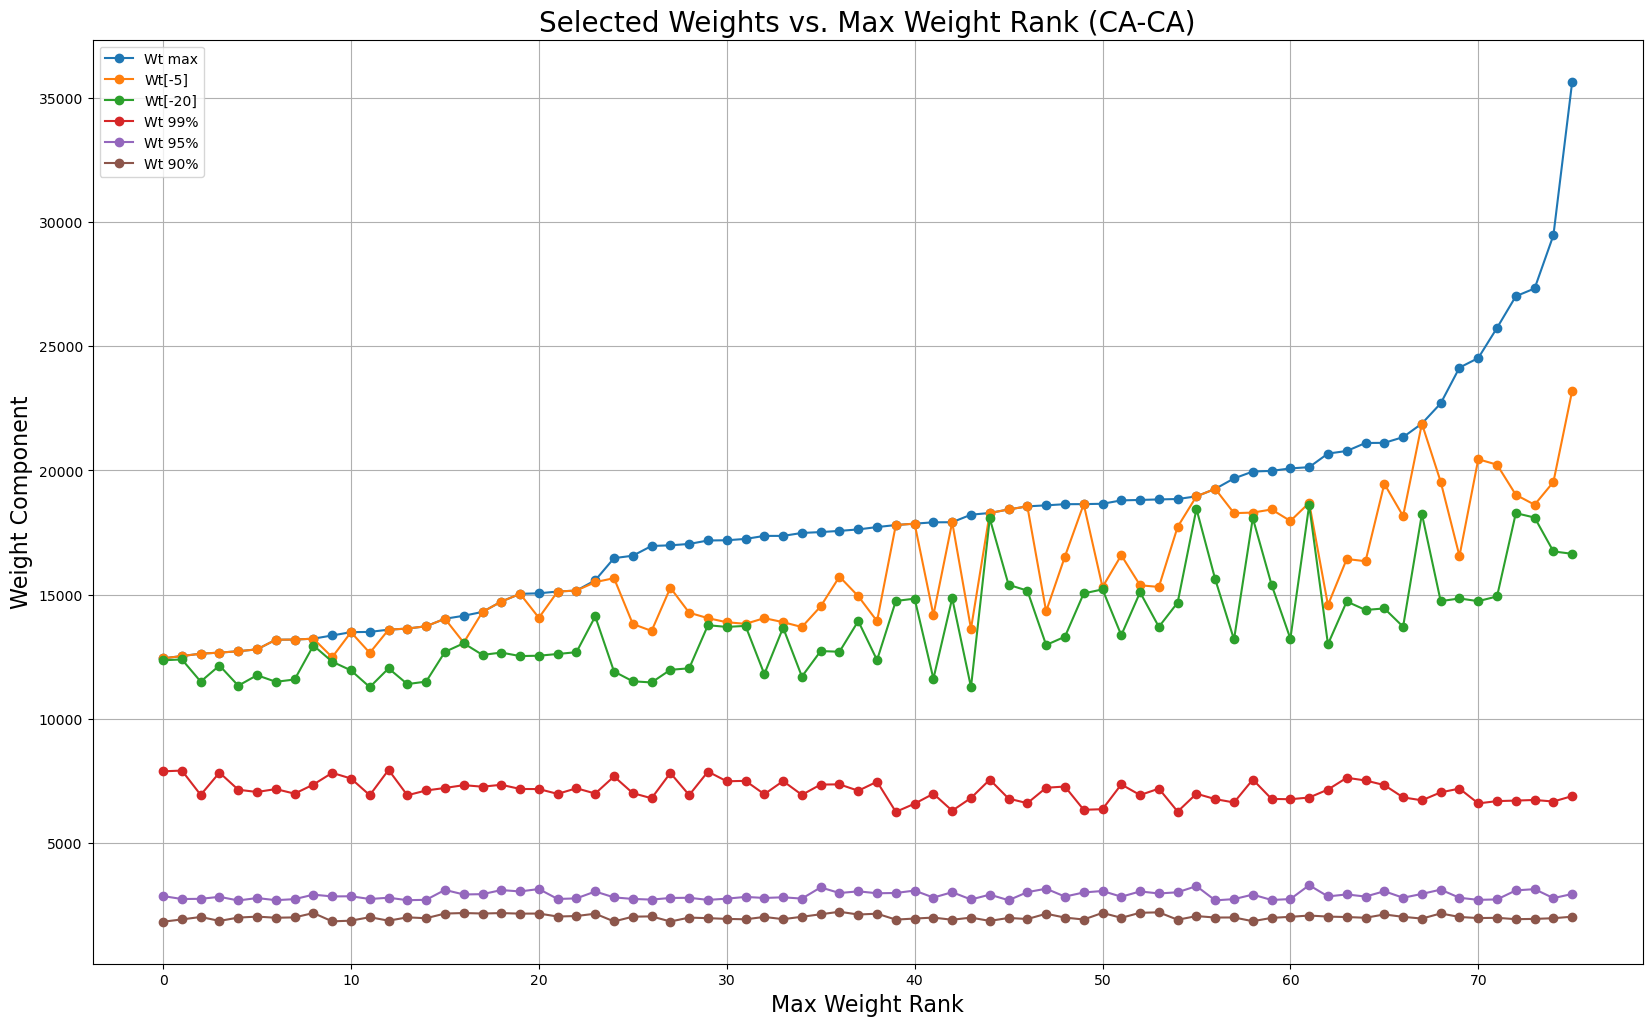

In [12]:
wts_max = []
wts_m1  = []
wts_m2  = []
wts_99  = []
wts_95  = []
wts_90  = []   
    
for index, row in result_df.iterrows():    
    model_index = row['Model Index']
    weights_m = weight_map[model_index]    
    sorted_weights = sorted(weights_m)
  
    wts_max.append(sorted_weights[-1])
    wts_m1.append(sorted_weights[-5])
    wts_m2.append(sorted_weights[-20])
    wts_99.append(np.percentile(weights_m, 99))
    wts_95.append(np.percentile(weights_m, 95))
    wts_90.append(np.percentile(weights_m, 90))
    
plt.figure(figsize=(20,12))
plt.plot(wts_max, label='Wt max', marker='o')
plt.plot(wts_m1, label='Wt[-5]', marker='o')
plt.plot(wts_m2, label='Wt[-20]', marker='o')
plt.plot(wts_99, label='Wt 99%', marker='o')
plt.plot(wts_95, label='Wt 95%', marker='o')
plt.plot(wts_90, label='Wt 90%', marker='o')
plt.xlabel('Max Weight Rank', fontsize=16)
plt.ylabel('Weight Component', fontsize=16)
plt.title('Selected Weights vs. Max Weight Rank ({0}-{1})'.format(SOURCE_STATE, TARGET_STATE), fontsize=20)
plt.grid()
plt.legend(loc='upper left')
plt.show()

### 2. Percentage of the population in the tail of the weight distribution

For each model in the table above, taken in order, compute the percentage of the population represented by these sets of the largest weights:
* Largest 8 weights
* Largest 16 weights
* Largest 32 weights

Ideally the upper tail of the weight distribution should only contain a small percentage of the overall population. Large percentages in the upper tail can indicate that the maximum weights are unrepresentative of the population as a whole.

In [13]:
# N largest weights
lim_data = [
    ( 8, [], 'Top 8'),
    (16, [], 'Top 16'),
    (32, [], 'Top 32'),
]

for index, row in result_df.iterrows():
    model_index = row['Model Index']
    weights_m = weight_map[model_index]
    sorted_weights = sorted(weights_m)
    
    for lim, arr, label in lim_data:
        
        if lim > len(sorted_weights):
            break
        
        # the nth-from-the-max weight
        wn = sorted_weights[-lim]

        # extract all weights >= this value
        samples = []
        for w in weights_m:
            assert w >= 0
            if w >= wn:
                samples.append(w)    
             
        # the weighted population in the top N weights
        pop = np.sum(samples)
        # pct of the target population this represents
        pct = 100.0 * (pop / target_population)
        arr.append(pct)

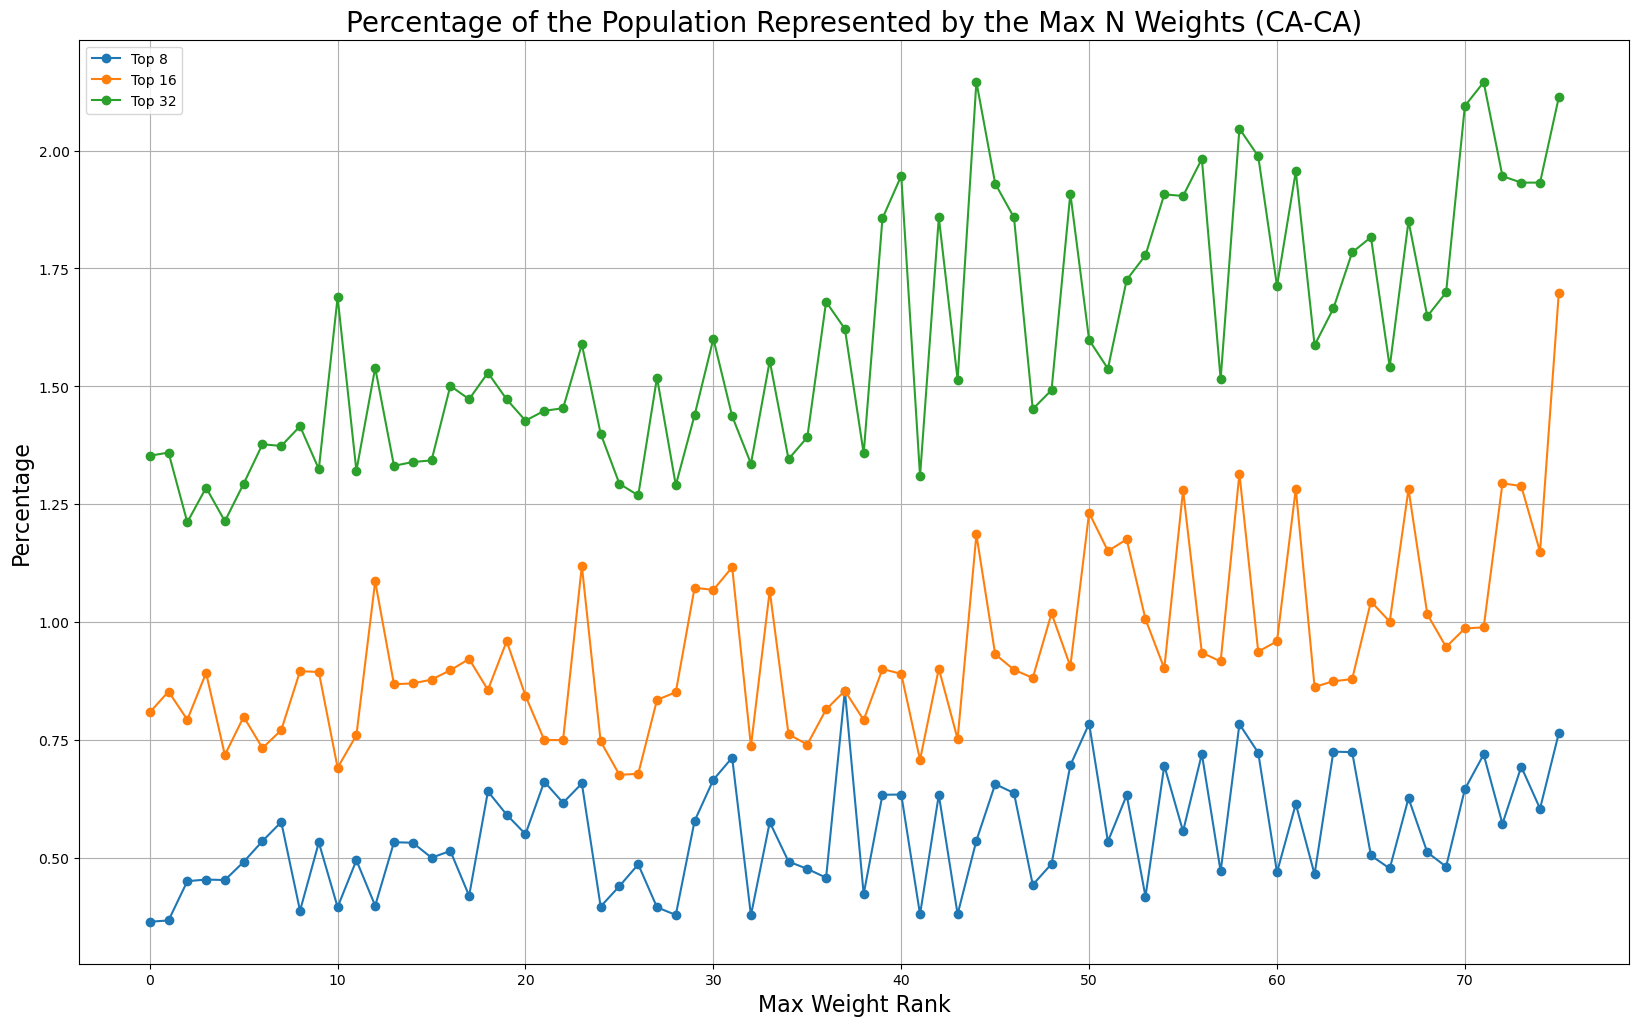

Top 8 percentage for best model: 0.365.


In [14]:
plt.figure(figsize=(20,12))
for lim, arr, label in lim_data:
    if lim > len(sorted_weights):
        continue
    plt.plot(arr, label=label, marker='o')
plt.xlabel('Max Weight Rank', fontsize=16)
plt.ylabel('Percentage', fontsize=16)
plt.title('Percentage of the Population Represented by the Max N Weights ({0}-{1})'.format(SOURCE_STATE,
                                                                                           TARGET_STATE),
          fontsize=20)
plt.grid()
plt.legend(loc='upper left')
plt.show()
print('Top 8 percentage for best model: {0:.3f}.'.format(lim_data[0][1][0]))

### 3. Percentage of the population greater than a cutoff weight

For each model in the table above, taken in order, compute the percentage of the population greater than a cutoff weight. The cutoff values are stated as a percentage of the maximum weight:
* 90% of the maximum weight
* 85% of the maximum weight
* 80% of the maximum weight
* 75% of the maximum weight

This plot give another perspective on the weights in the upper tail of the weight distribution.

In [15]:
# pct of population >= cutoff weight
max_data = [
    (90, [], '90%'),
    (85, [], '85%'),
    (80, [], '80%'),
    (75, [], '75%'),
]

for index, row in result_df.iterrows():
    model_index = row['Model Index']
    weights_m = weight_map[model_index]
    sorted_weights = sorted(weights_m)

    for pct, arr, label in max_data:
        wmax = np.max(weights_m)
        cutoff = pct * 0.01 * wmax
        # extract all weights >= cutoff
        samples = []
        for w in weights_m:
            if w >= cutoff:
                samples.append(w)
        
        # fraction of the population in these weights
        pop_fraction = np.sum(samples) / target_population
        arr.append(pop_fraction * 100.0)        

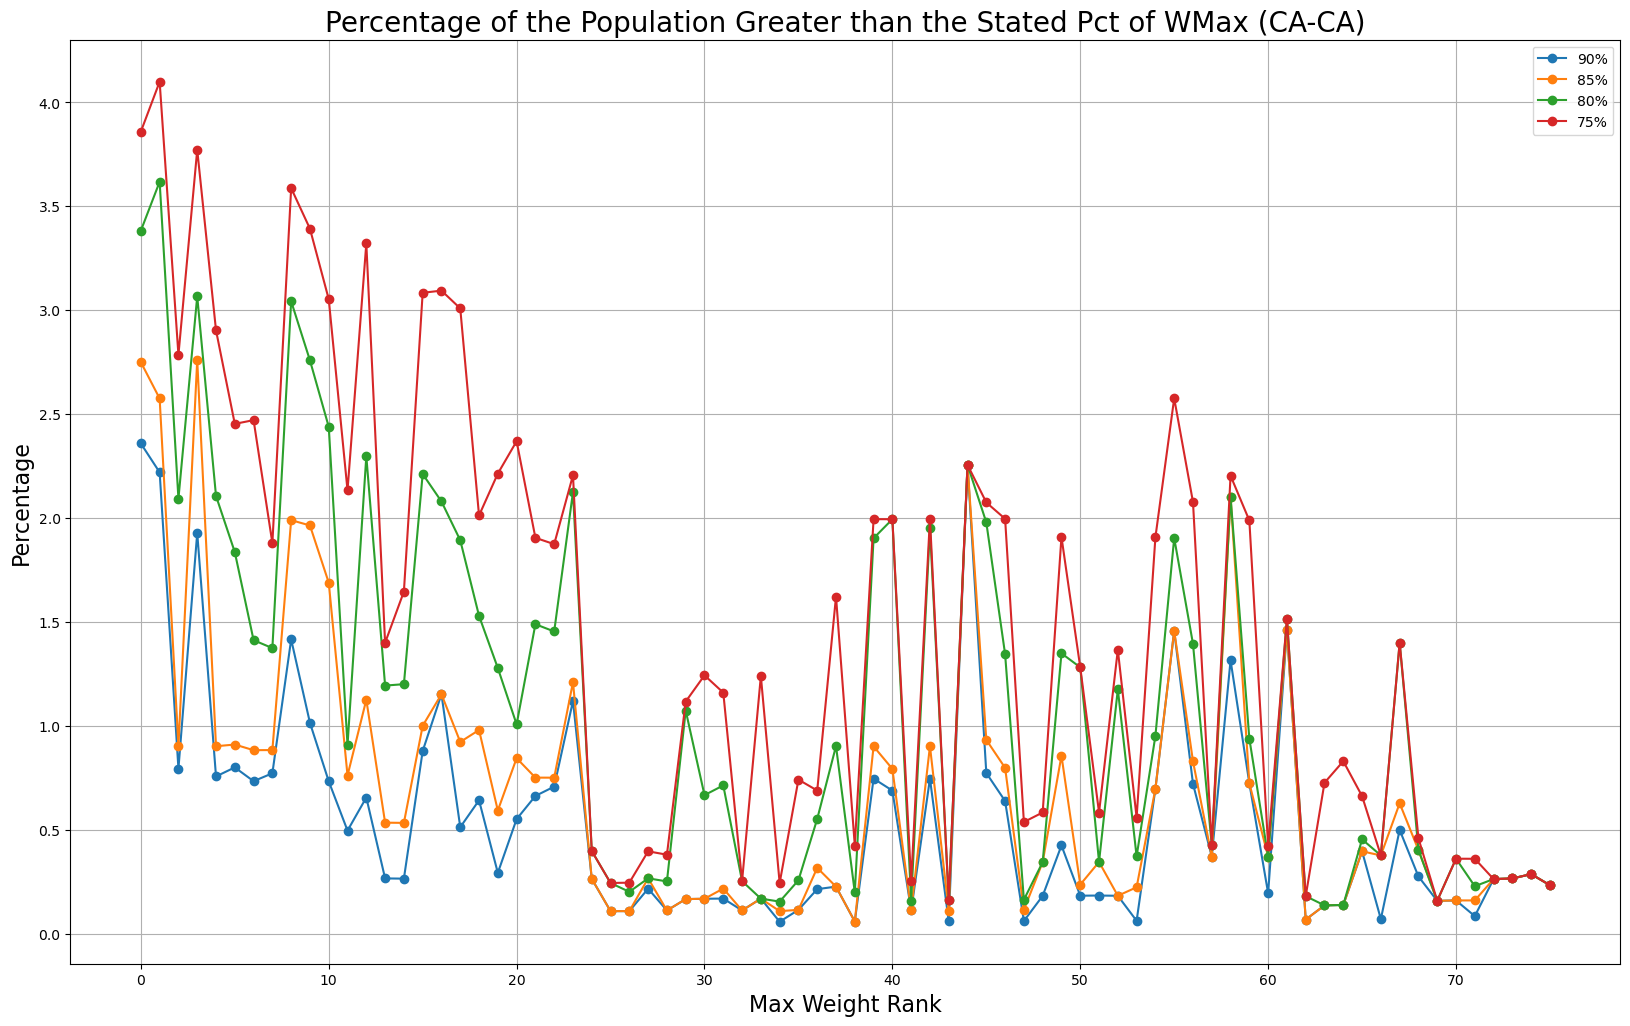

In [16]:
plt.figure(figsize=(20,12))
for lim, arr, label in max_data:
    if lim > len(sorted_weights):
        continue
    plt.plot(arr, label=label, marker='o')
plt.xlabel('Max Weight Rank', fontsize=16)
plt.ylabel('Percentage', fontsize=16)
plt.title('Percentage of the Population Greater than the Stated Pct of WMax ({0}-{1})'.
          format(SOURCE_STATE, TARGET_STATE), fontsize=20)
plt.grid()
plt.legend(loc='upper right')
plt.show()

### 4. Weight distribution for the model with the smallest maximum weight

Plot a histogram of the weights for the model in the first row in the table above.

In [17]:
best_model_index = result_df.iloc[[0]]['Model Index'][0]
best_model = str(result_df.iloc[[0]]['Model'][0])
best_weights = weight_map[best_model_index]

In [18]:
def plot_weight_distribution(plot_weights, title):
    
    fig = plt.figure(figsize=(16,8))
    plt.hist(plot_weights, bins=100, edgecolor='k', alpha=0.5)
    plt.xlabel('$w_i$', fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.title(title, fontsize=18)
    plt.yscale('log')
    plt.grid()
    plt.show()    

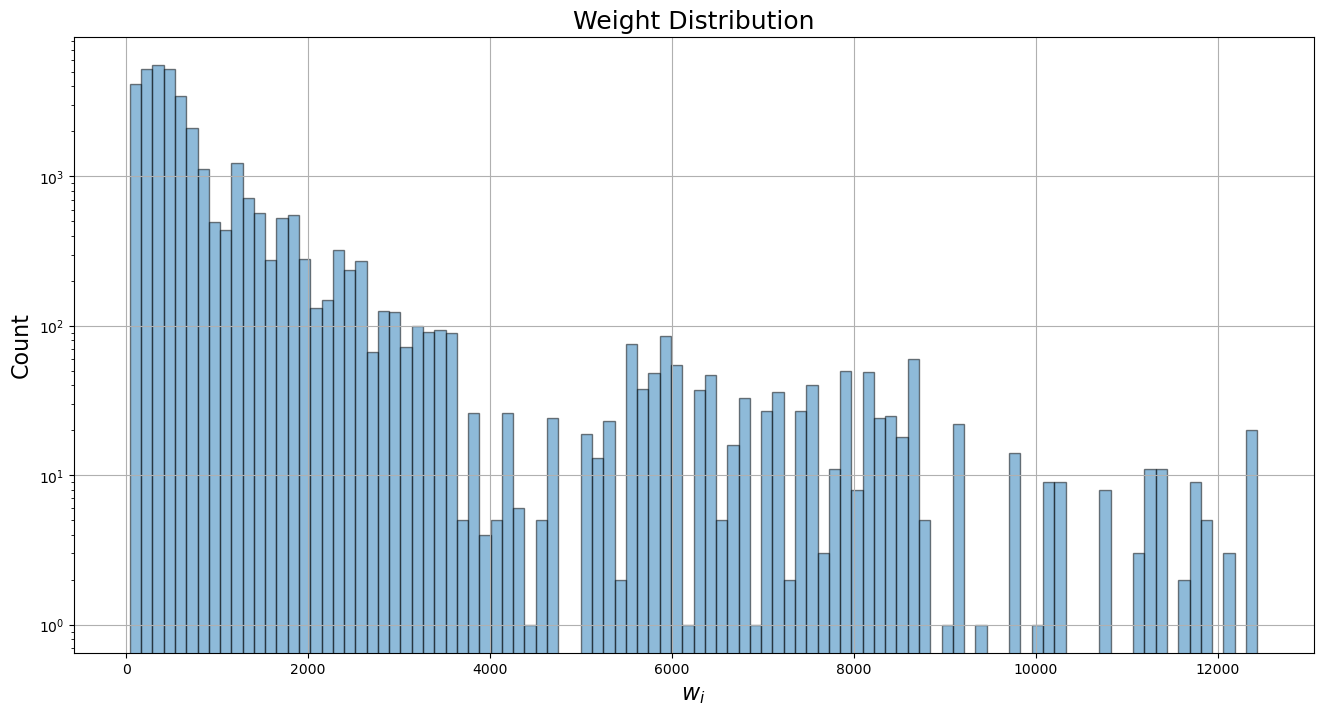

In [19]:
plot_weight_distribution(best_weights, 'Weight Distribution')

#### 4.1: Check for zero-weight individuals

Zero weights will be assigned to any source individual with a combination of features that are **not** found in the target population.

In [20]:
# source data using "best" weight distribution
best_df = source_df.copy()
best_df = best_df.assign(**{'Weight':best_weights})
zero_df = best_df.loc[best_df['Weight'] == 0]
display(zero_df)
print('\nFound {0} zero-weight source records.'.format(len(zero_df)))

#
# ensure that none of these individuals appears in the target data
#

# drop the weight col, not needed for these checks
zero_df = zero_df.drop(columns=['Weight'])

# convert df to set of tuples
zero_wt_tup_set = set(zero_df.itertuples(index=False, name=None))

# drop the weight col from the pums df
if TARGET_WEIGHT_COL is not None:
    target_no_wt_df = target_df.drop(columns=[TARGET_WEIGHT_COL])
else:
    target_no_wt_df = target_df
target_tup_set = set(target_no_wt_df.itertuples(index=False, name=None))

# these sets should be disjoint, meaning that none of the zero wt tuples occur in the PUMS population
error_population = len(zero_wt_tup_set.intersection(target_tup_set))
    
# this number should be zero
print('Number of zero-weight source records found in the target population: {0}.'.format(error_population))

,AGE_GROUPING,RACE_GROUPING,INSURANCE_GROUPING,EDUCATION_GROUPING,INCOME_GROUPING,SEX_AT_BIRTH,STATE,Weight



Found 0 zero-weight source records.
Number of zero-weight source records found in the target population: 0.


#### 4.2: Find the source records with the largest weights

The records with the largest weights indicate the combinations of characterists that are relatively less common in the target population.

In [21]:
nonzero_weights = best_weights[best_weights > 0]
sorted_weights = sorted(nonzero_weights, reverse=True)
max_wt_df = best_df[best_df['Weight'].isin(sorted_weights[:10])]
max_wt_df = max_wt_df.sort_values(by=['Weight'], ascending=False)
max_wt_df

,AGE_GROUPING,RACE_GROUPING,INSURANCE_GROUPING,EDUCATION_GROUPING,INCOME_GROUPING,SEX_AT_BIRTH,STATE,Weight
710,0,3,0,1,0,0,CA,12432.680586
17202,0,3,0,1,0,0,CA,12432.680586
34365,0,3,0,1,0,0,CA,12432.680586
29174,0,3,0,1,0,0,CA,12432.680586
2555,0,3,0,1,0,0,CA,12432.680586
20309,0,3,0,1,0,0,CA,12432.680586
10434,0,3,0,1,0,0,CA,12432.680586
6232,0,3,0,1,0,0,CA,12432.680586
5893,0,3,0,1,0,0,CA,12432.680586
14177,0,3,0,1,0,1,CA,12354.784468


### 5. Univariate distributions for the model with the smallest maximum weight


Compute the weighted source univariate distributions and compare with the target distributions. If the raking procedure was successful, the two distributions should be nearly identical.

In [22]:
bin_counts     = raking.bin_counts()
source_samples = raking.source_samples()
target_samples = raking.target_samples()

# target pdfs
target_pdfs = {}
for q in range(len(RAKE_DATA)):
    target_pdfs[q] = pdf.to_pdf(bin_counts[q], target_samples[q], weights=target_df[TARGET_WEIGHT_COL].values)

# unraked source pdfs
source_unraked_pdfs = {}
for q in range(len(RAKE_DATA)):
    source_unraked_pdfs[q] = pdf.to_pdf(bin_counts[q], source_samples[q], weights=None)

# raked source pdfs
source_raked_pdfs = {}
for q in range(len(RAKE_DATA)):
    source_raked_pdfs[q] = pdf.to_pdf(bin_counts[q], source_samples[q], weights=best_weights)

print('Univariate Distributions for {0}-{1}, model {2}:\n'.format(SOURCE_STATE, TARGET_STATE, best_model))

# display precision
P = 5
for q in range(len(RAKE_DATA)):
    enumvar = RAKE_DATA[q][0]
    var_name = CODING.VAR_NAMES[enumvar]
    print('{0}: '.format(var_name))
    print('\tUnweighted source PDF : {0}'.format(np.array_str(source_unraked_pdfs[q], precision=P)))
    print('\t  Weighted source PDF : {0}'.format(np.array_str(source_raked_pdfs[q],   precision=P)))
    print('\t           Target PDF : {0}'.format(np.array_str(target_pdfs[q],         precision=P)))    
    
print('\nPDF diffs after raking for model {0}:\n'.format(best_model))   

# diff between raked and target pdfs
diffs = []
for q in range(len(RAKE_DATA)):
    enumvar = RAKE_DATA[q][0]
    var_name = CODING.VAR_NAMES[enumvar]
    diff = abs(source_raked_pdfs[q] - target_pdfs[q])
    diffs.append(diff)
    print('{0:>{2}} : {1}'.format(var_name,
                                  np.array_str(diff, precision=5, suppress_small=True),
                                  maxlen))

# check the diff vectors for the presence of any diff > 0.01 (i.e. 1%)
all_ok = True
THRESHOLD = 0.01
for diff_vector in diffs:
    if np.any(diff_vector > THRESHOLD):
        all_ok = False

# sum of the weights
sum_of_weights = np.sum(best_weights)
print()
print('Min weight : {0:.3f}'.format(np.min(best_weights)))
print('Max weight : {0:.3f}'.format(np.max(best_weights)))
print()
print('Sum of the weights : {0:.3f}'.format(sum_of_weights))
print('  Population total : {0:.3f}'.format(target_population))
print('        Difference : {0:.3f}'.format(abs(target_population - sum_of_weights)))
print('\nRaked PDFs differ from target PDFs by less than {0}%: {1}'.format(int(THRESHOLD * 100),
                                                                           all_ok))

Univariate Distributions for CA-CA, model [[0], [2], [3], [5], [1, 4]]:

Age: 
	Unweighted source PDF : [0.18011 0.1632  0.16277 0.17574 0.16763 0.15054]
	  Weighted source PDF : [0.22109 0.18655 0.16522 0.16067 0.13686 0.1296 ]
	           Target PDF : [0.22109 0.18655 0.16522 0.16067 0.13686 0.1296 ]
RaceEth: 
	Unweighted source PDF : [0.63646 0.11514 0.06171 0.1706  0.01609]
	  Weighted source PDF : [0.39487 0.05697 0.15647 0.35747 0.03422]
	           Target PDF : [0.39487 0.05697 0.15647 0.35747 0.03422]
Insurance: 
	Unweighted source PDF : [0.90326 0.09674]
	  Weighted source PDF : [0.90753 0.09247]
	           Target PDF : [0.90753 0.09247]
Education: 
	Unweighted source PDF : [0.3386  0.1376  0.19526 0.32854]
	  Weighted source PDF : [0.39794 0.23162 0.21862 0.15182]
	           Target PDF : [0.39794 0.23162 0.21862 0.15182]
Income: 
	Unweighted source PDF : [0.16026 0.2     0.30677 0.33297]
	  Weighted source PDF : [0.45243 0.21807 0.19546 0.13404]
	           Target PDF : [0.

In [23]:
def plot_pdfs(source_unraked_pdfs, source_raked_pdfs, target_pdfs, source_state, target_state):
    """
    Plot the unraked source, raked source, and target univariate distributions.
    The raked source and target bars should be nearly identical in height.
    """
    
    # display precision
    P = 5
    
    num_pdfs = len(source_unraked_pdfs)
    assert len(source_raked_pdfs) == len(target_pdfs) == num_pdfs
    
    #for q in range(num_pdfs):
    for q in range(len(RAKE_DATA)):
        enumvar = RAKE_DATA[q][0]
        var_name = CODING.VAR_NAMES[enumvar]
        plots.triple_histogram_from_pdfs('{0} ({1}-{2})'.format(var_name, source_state, target_state), 
                                         source_unraked_pdfs[q], source_raked_pdfs[q], target_pdfs[q],
                                         labels=['Unraked Source', 'Raked Source', 'Target'])
        print('Unweighted source PDF : {0}'.format(np.array_str(source_unraked_pdfs[q], precision=P)))
        print('  Weighted source PDF : {0}'.format(np.array_str(source_raked_pdfs[q],   precision=P)))
        print('           Target PDF : {0}'.format(np.array_str(target_pdfs[q],         precision=P)))

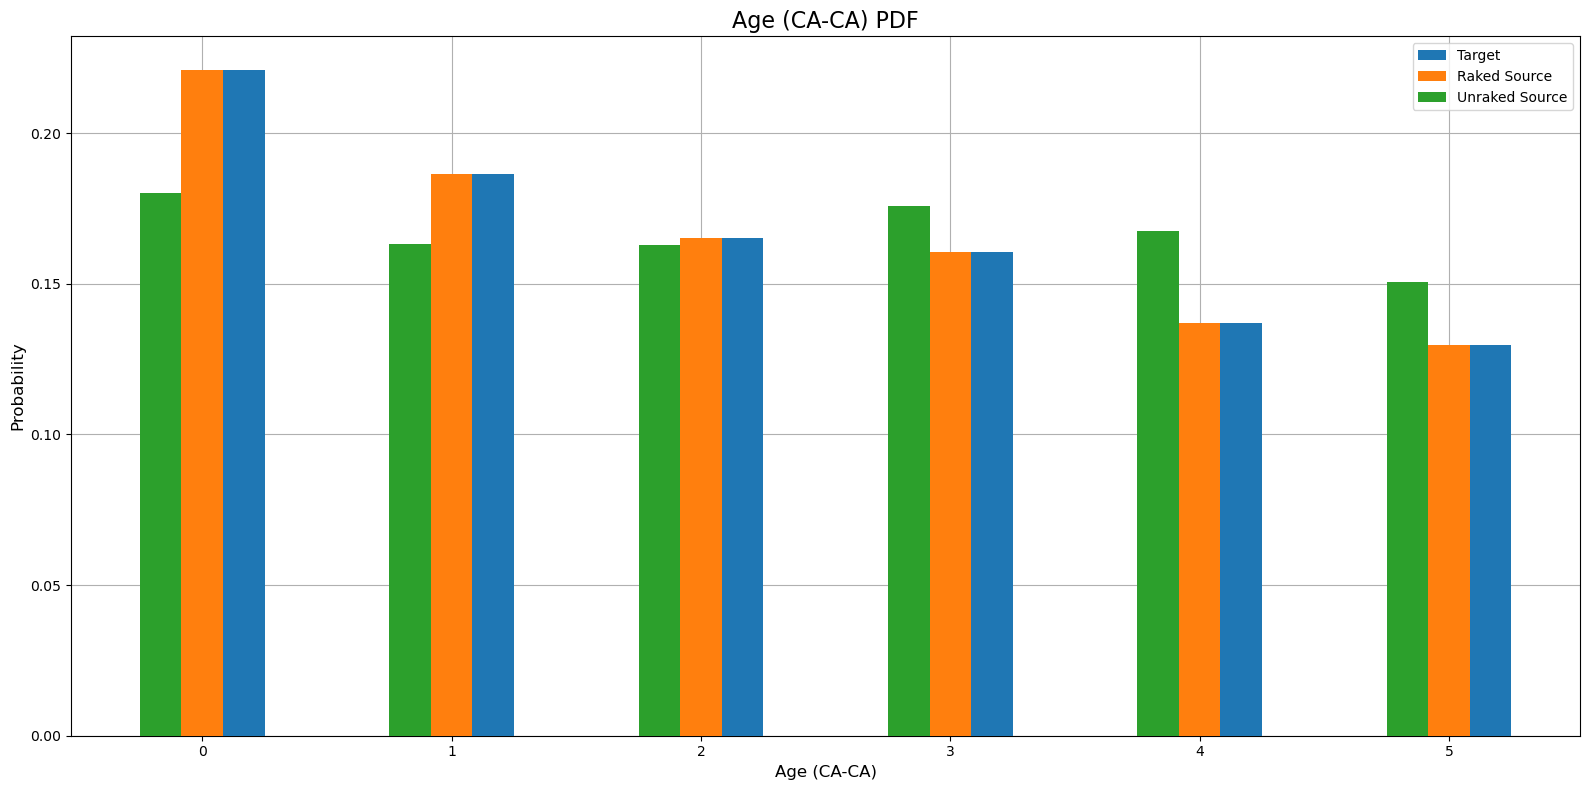

Unweighted source PDF : [0.18011 0.1632  0.16277 0.17574 0.16763 0.15054]
  Weighted source PDF : [0.22109 0.18655 0.16522 0.16067 0.13686 0.1296 ]
           Target PDF : [0.22109 0.18655 0.16522 0.16067 0.13686 0.1296 ]


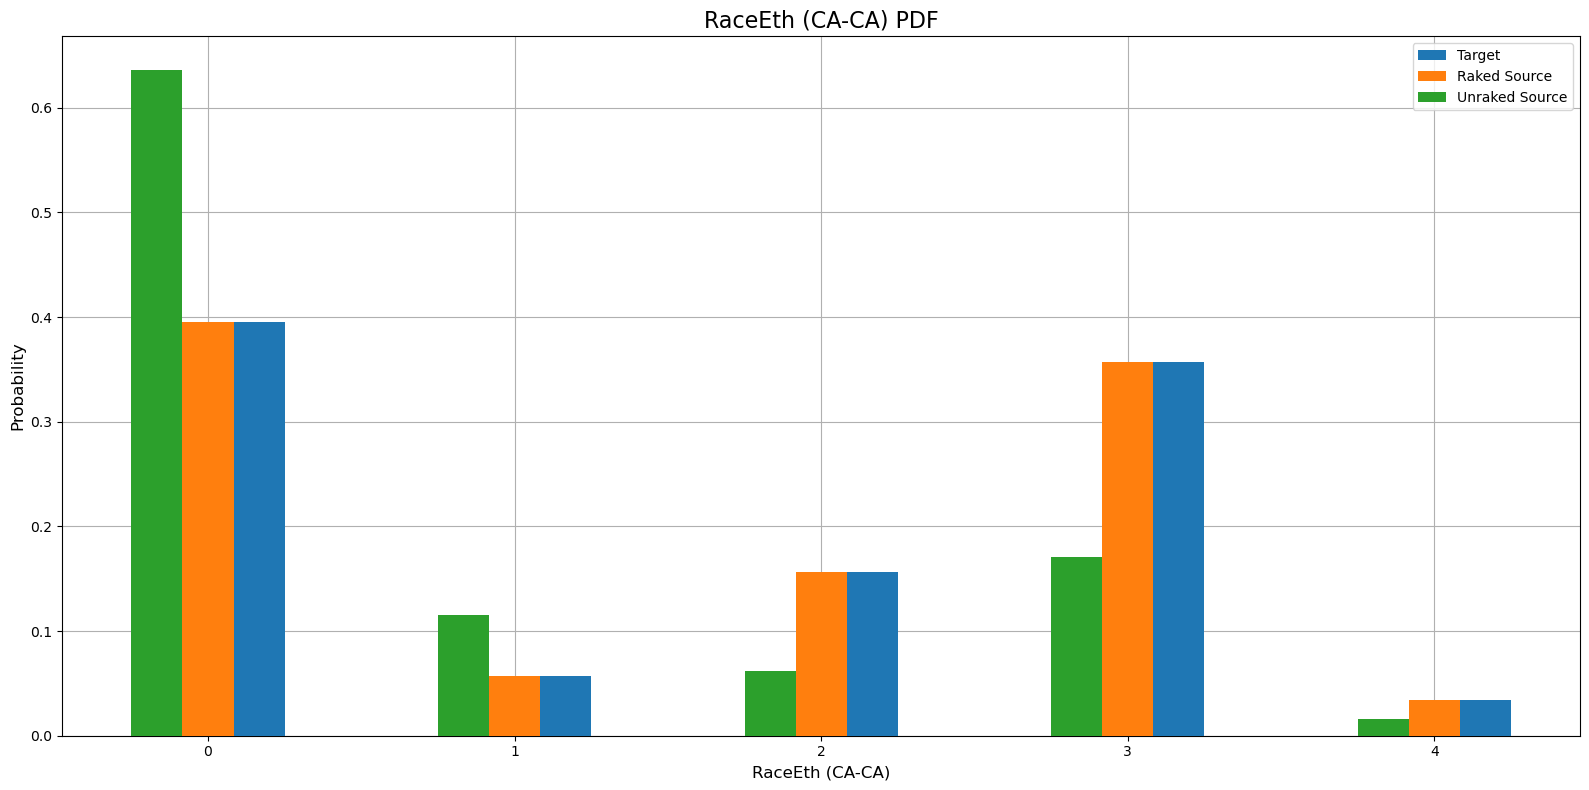

Unweighted source PDF : [0.63646 0.11514 0.06171 0.1706  0.01609]
  Weighted source PDF : [0.39487 0.05697 0.15647 0.35747 0.03422]
           Target PDF : [0.39487 0.05697 0.15647 0.35747 0.03422]


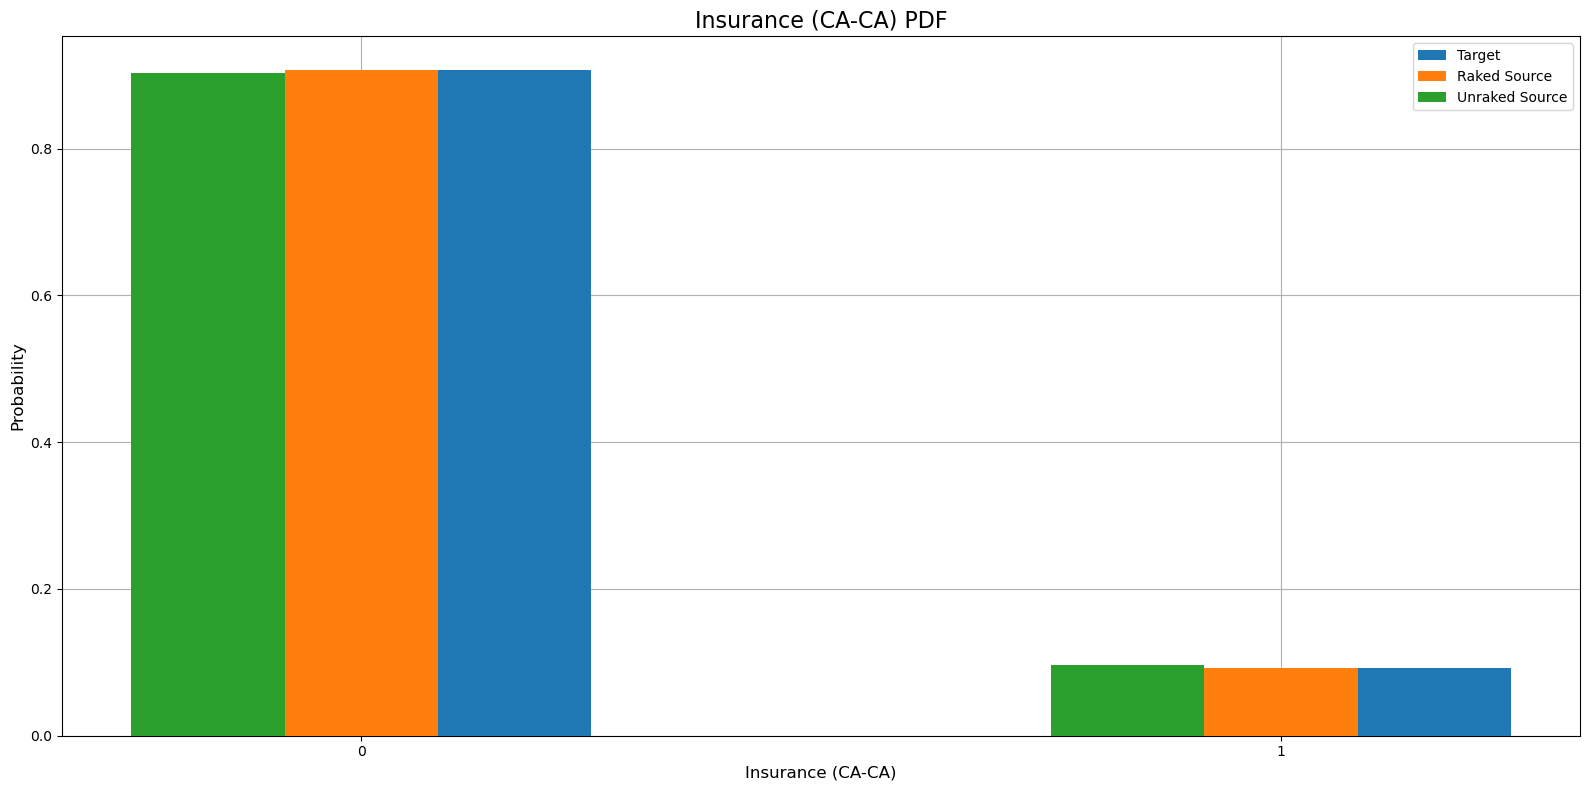

Unweighted source PDF : [0.90326 0.09674]
  Weighted source PDF : [0.90753 0.09247]
           Target PDF : [0.90753 0.09247]


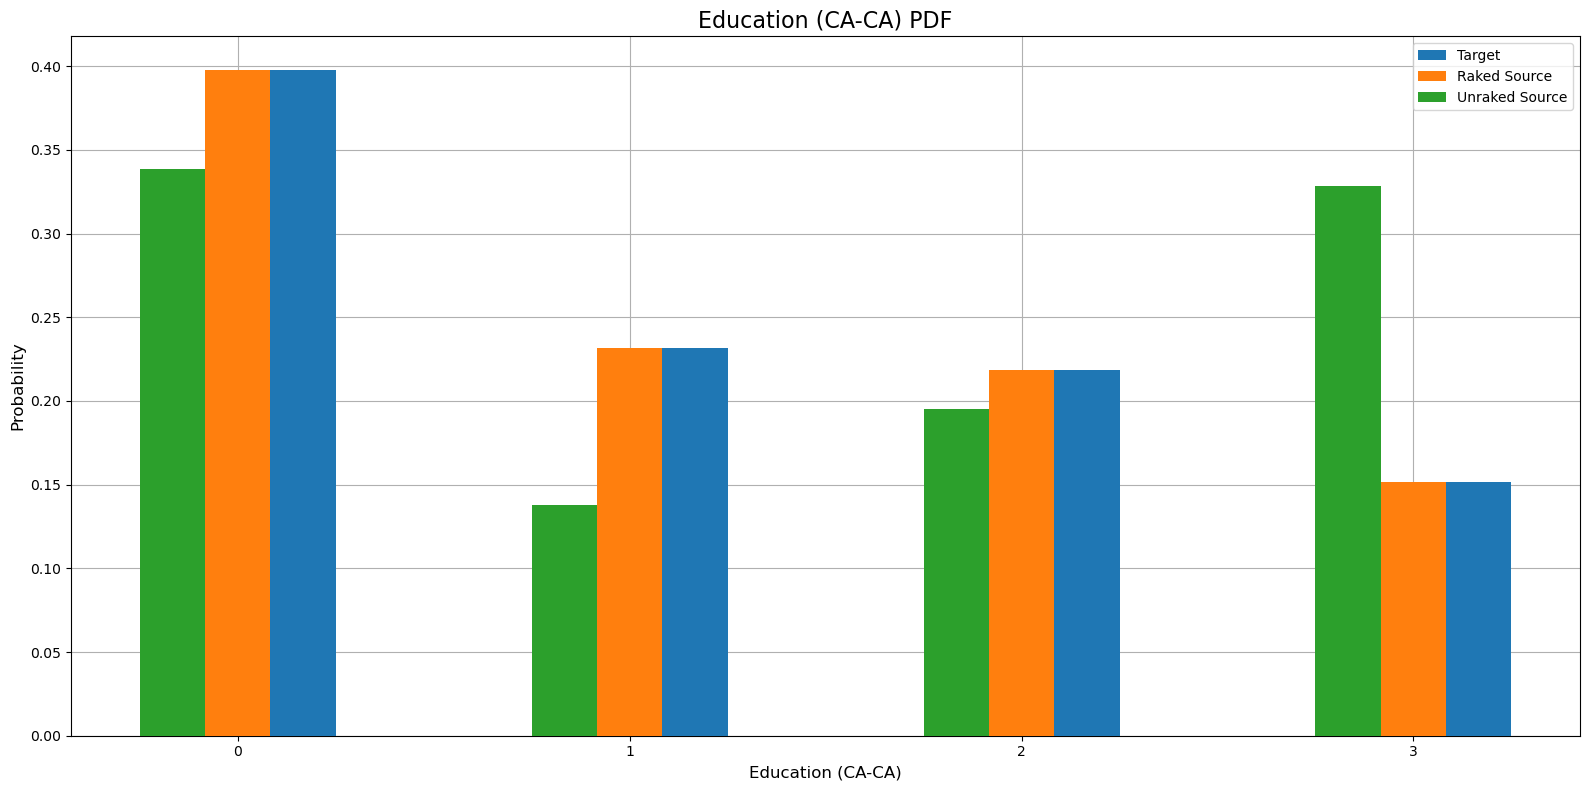

Unweighted source PDF : [0.3386  0.1376  0.19526 0.32854]
  Weighted source PDF : [0.39794 0.23162 0.21862 0.15182]
           Target PDF : [0.39794 0.23162 0.21862 0.15182]


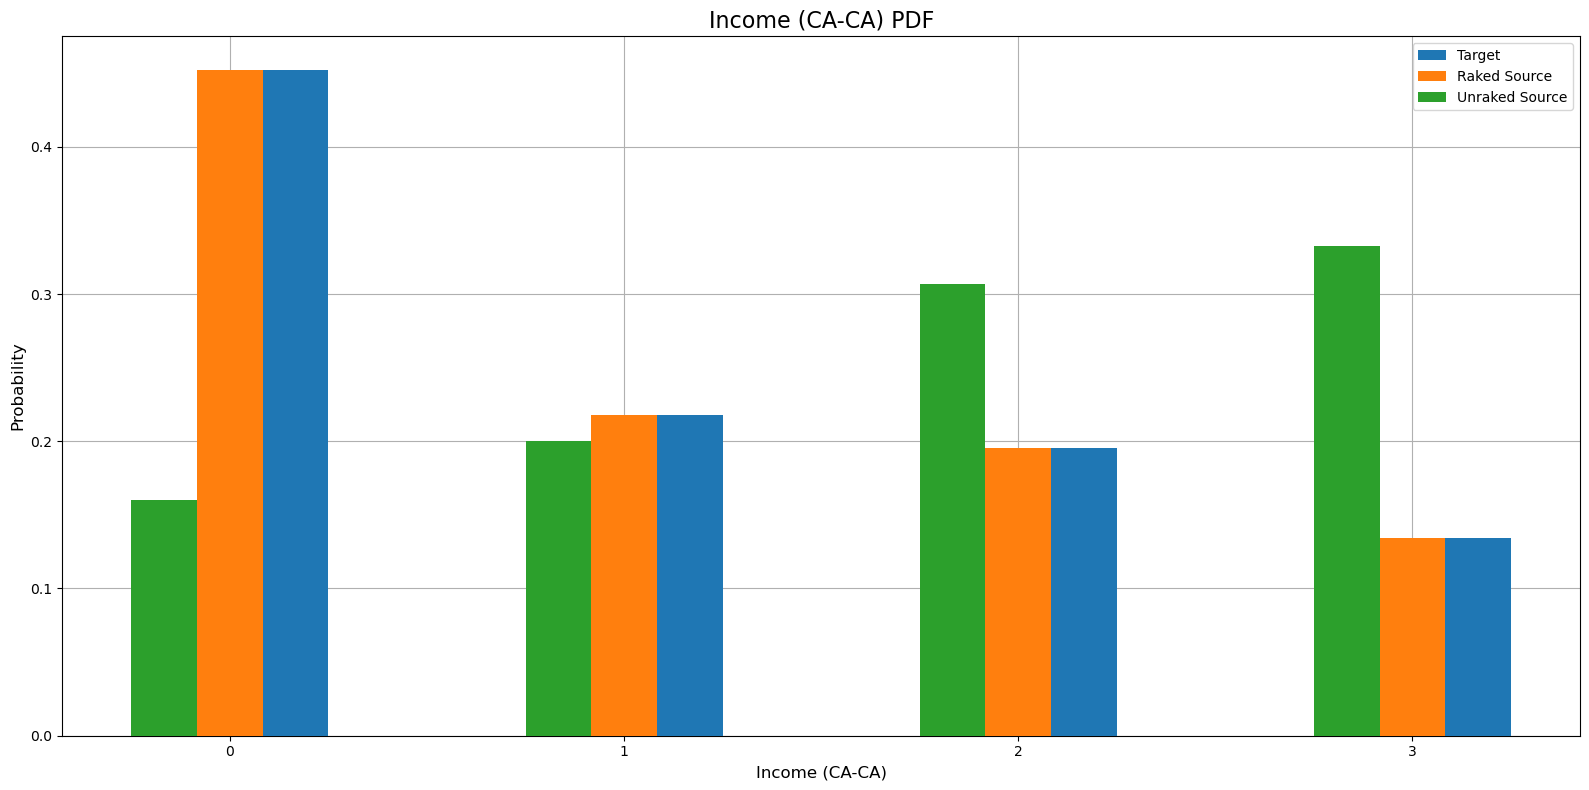

Unweighted source PDF : [0.16026 0.2     0.30677 0.33297]
  Weighted source PDF : [0.45243 0.21807 0.19546 0.13404]
           Target PDF : [0.45243 0.21807 0.19546 0.13404]


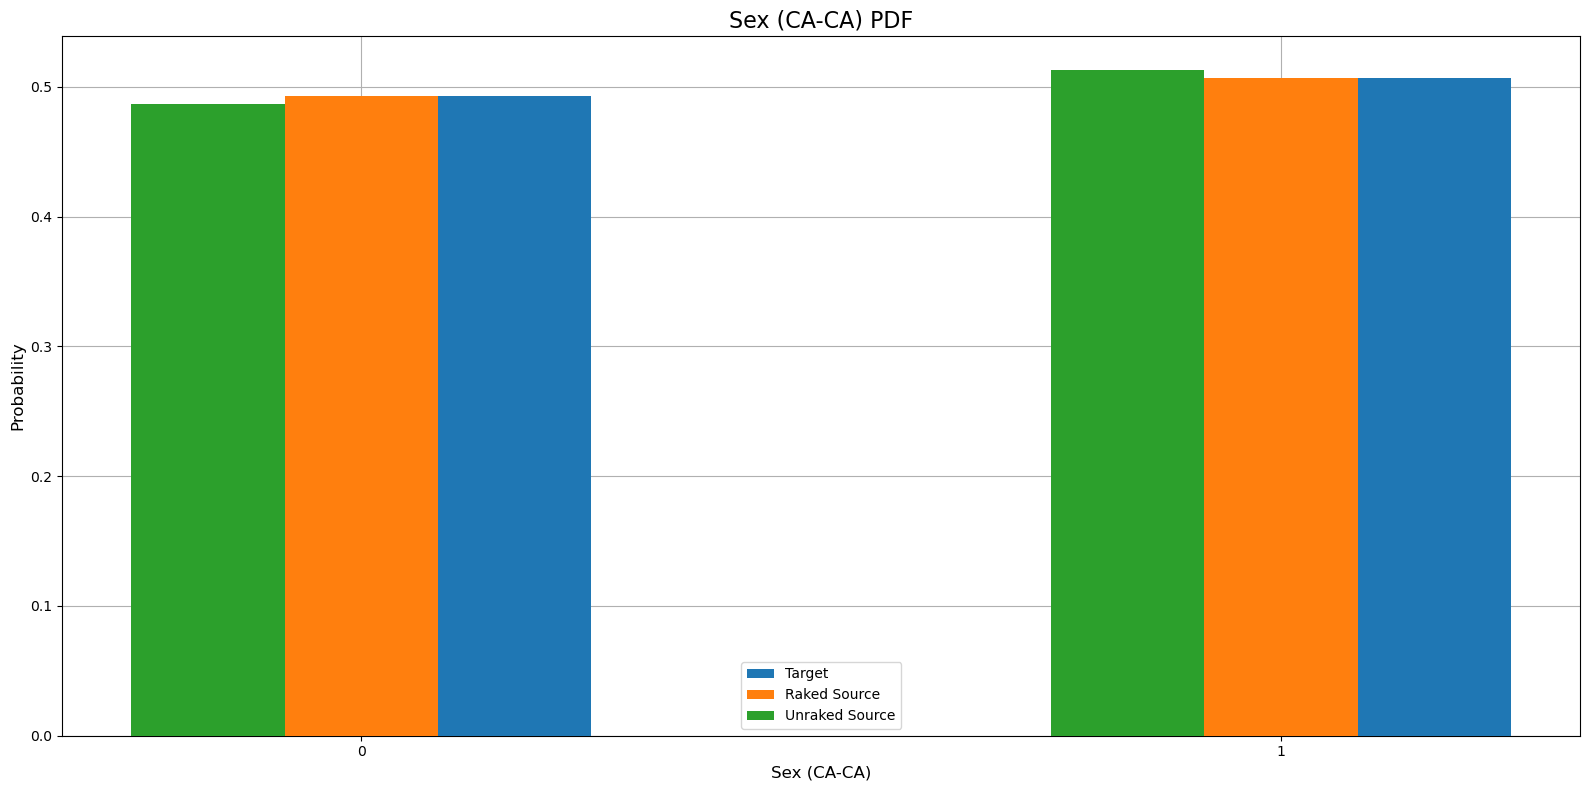

Unweighted source PDF : [0.48686 0.51314]
  Weighted source PDF : [0.49317 0.50683]
           Target PDF : [0.49317 0.50683]


In [24]:
plot_pdfs(source_unraked_pdfs, source_raked_pdfs, target_pdfs, SOURCE_STATE, TARGET_STATE)